Epoch 1/100
136/136 [==============================] - 11s 46ms/step - loss: 0.0149 - val_loss: 0.0018
Epoch 2/100
  3/136 [..............................] - ETA: 4s - loss: 0.0039

C:\Users\SRI NIDHI\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 5s 38ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 3/100
136/136 [==============================] - 5s 35ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 4/100
136/136 [==============================] - 5s 35ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 5/100
136/136 [==============================] - 5s 35ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 6/100
136/136 [==============================] - 5s 37ms/step - loss: 0.0026 - val_loss: 9.3673e-04
Epoch 7/100
136/136 [==============================] - 5s 35ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/100
136/136 [==============================] - 5s 39ms/step - loss: 0.0025 - val_loss: 9.3475e-04
Epoch 9/100
136/136 [==============================] - 5s 35ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 10/100
136/136 [==============================] - 6s 43ms/step - loss: 0.0021 - val_loss: 8.0513e-04
Epoch 11/100
136/136 [==============================] - 5s 40ms/step - loss: 0.00

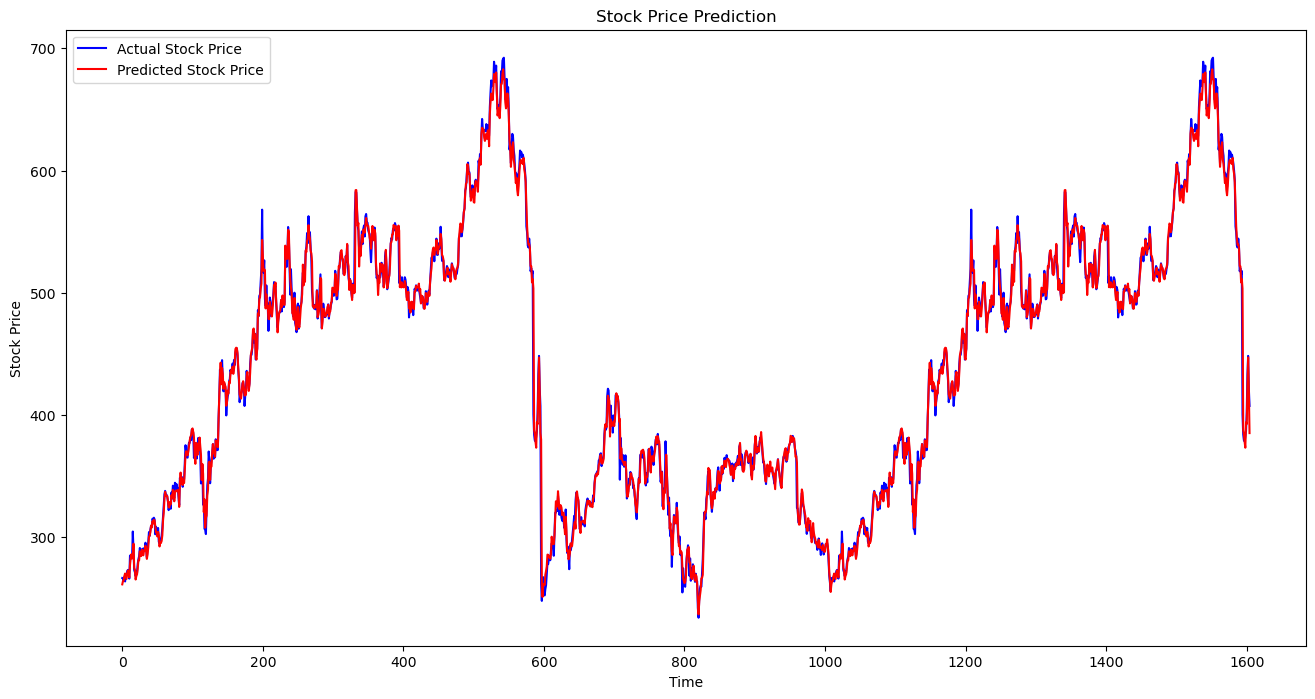

Mean Absolute Error (MAE): 4.20
Mean Squared Error (MSE): 61.41
Root Mean Squared Error (RMSE): 7.84
R-squared (R2): 0.99
Accuracy Percentage: 92.65%


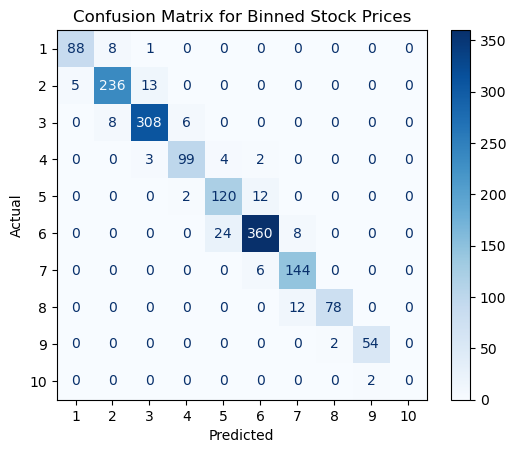

Custom Accuracy: 0.73
Custom Precision: 0.73


In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import TimeSeriesSplit

# Load the data
url = "https://drive.google.com/uc?export=download&id=1ibLsFTImEKUTCD0y23Z__rQNroj00GDW"
data = pd.read_csv(url)


# Preprocess the data
data["Date"] = pd.to_datetime(data["Date"])
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
data.set_index('Date', inplace=True)

# Duplicate the dataset to increase training data
data = pd.concat([data, data], ignore_index=False)

# Feature engineering: manually calculate SMA, RSI, Bollinger Bands, and MACD
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

def calculate_rsi(data, window):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_bollinger_bands(data, window):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band

def calculate_macd(data, slow=26, fast=12):
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    return ema_fast - ema_slow

data['SMA'] = calculate_sma(data['Close'], 30)
data['RSI'] = calculate_rsi(data['Close'], 14)
data['Upper_BB'], data['Lower_BB'] = calculate_bollinger_bands(data['Close'], 20)
data['MACD'] = calculate_macd(data['Close'])
data.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create features and labels for LSTM
def create_features(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len][0])  # Predicting 'Open' price
    return np.array(X), np.array(y)

seq_len = 60  # Sequence length for LSTM
X, y = create_features(scaled_data, seq_len)

# Split the data into training and testing sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
X_train, X_test, y_train, y_test = [], [], [], []
for train_index, test_index in tscv.split(X):
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])

X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping and model checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[early_stop, model_checkpoint])

# Load the best model
model.load_weights('best_model.h5')

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack([predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))]))[:, 0]
y_test_actual = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))]))[:, 0]

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate the model
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

# Calculate accuracy and precision using binned predictions
num_bins = 10
bins = np.linspace(min(y_test_actual.min(), predictions.min()), max(y_test_actual.max(), predictions.max()), num_bins)

y_test_binned = np.digitize(y_test_actual.flatten(), bins)
predictions_binned = np.digitize(predictions.flatten(), bins)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_binned, predictions_binned, labels=np.arange(1, num_bins + 1))

# Calculate accuracy percentage using accuracy_score
accuracy_percentage = accuracy_score(y_test_binned, predictions_binned) * 100
print(f'Accuracy Percentage: {accuracy_percentage:.2f}%')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(1, num_bins + 1))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Binned Stock Prices')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Custom accuracy and precision calculation
threshold = 5  # Define a threshold for acceptable prediction error
correct_predictions = np.sum(np.abs(y_test_actual.flatten() - predictions.flatten()) <= threshold)
total_predictions = len(predictions.flatten())

accuracy = correct_predictions / total_predictions
precision = np.mean(np.abs(y_test_actual.flatten() - predictions.flatten()) <= threshold)

print(f'Custom Accuracy: {accuracy:.2f}')
print(f'Custom Precision: {precision:.2f}')
